# Customer Assignment Problem

## Motivation

Many companies in various industries must make strategic decisions about where to build facilities to support their operations. 
For example:

- Producers of goods need to decide how to design their **supply chains** – which encompass factories, distribution centers, warehouses, and retail stores.
- **Healthcare providers** need to determine where to build hospitals to maximize their population coverage.

These are strategic decisions that are difficult to implement and costly to change because they entail long-term investments. Furthermore, these decisions have a significant impact, both in terms of customer satisfaction and cost management. One of the critical factors to consider in this process is the location of the customers that the company is planning to serve.

---
## Problem Description

The Customer Assignment Problem is closely related to the Facility Location Problem, which is concerned with the optimal placement of facilities (from a set of candidate locations) in order to minimize the distance between the facilities and the customers. When the facilities have unlimited capacity, customers are assumed to be served by the closest facility. 

In cases where the number of customers is too big, they can be grouped into clusters. Then, the cluster centers can be used in lieu of the individual customer locations. This pre-processing makes the assumption that all customers belonging to a given cluster will be served by the facility assigned to that cluster. The k-means algorithm can be used for this task, which aims to partition $n$ objects into $k$ distinct and non-overlapping clusters.

---
## Solution Approach

We now present a **Binary Integer Programming** (BIP) formulation:

### Sets and Indices:
- $i \in I$: Set of customer clusters.

- $j \in J$: Set of potential facility locations.

- $\text{Pairings}= \{(i,j) \in I \times J: \text{dist}_{i,j} \leq \text{threshold}\}$: Set of allowed pairings

### Parameters:
- $\text{threshold} \in \mathbb{R}^+$: Maximum distance for a cluster-facility pairing to be considered.

- $\text{max_facilities} \in \mathbb{N}$: Maximum number of facilities to be opened.

- $\text{weight}_i \in \mathbb{N}$: Number of customers in cluster $i$.

- $\text{dist}_{i,j} \in \mathbb{R}^+$: Distance from cluster $i$ to facility location $j$.

### Decision Variables:
- $\text{select}_j \in \{0,1\}$: 1 if facility location $j$ is selected; 0 otherwise.

- $\text{assign}_{i,j} \in \{0,1\}$: 1 if cluster $i$ is assigned to facility location $j$; 0 otherwise.

### Objective Function:

- **Total distance**: Minimize the total distance from clusters to their assigned facility:

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Pairings}}\text{weight}_i \cdot \text{dist}_{i,j} \cdot \text{assign}_{i,j}
\tag{0}
\end{equation}


### Constraints:

- **Facility limit**: The number of facilities cannot exceed the limit:

\begin{equation}
\sum_{j}\text{select}_j \leq \text{max_facilities}
\tag{1}
\end{equation}

- **Open to assign**: Cluster $i$ can only be assigned to facility $j$ if we decide to build that facility:

\begin{equation}
\text{assign}_{i,j} \leq \text{select}_{j} \quad \forall (i,j) \in \text{Pairings}
\tag{2}
\end{equation}

- **Closest store**: Cluster $i$ must be assigned to exactly one facility:

\begin{equation}
\sum_{j:(i,j) \in \text{Pairings}}\text{assign}_{i,j} = 1 \quad \forall i \in I
\tag{3}
\end{equation}


---
## Python Implementation


In [1]:
%matplotlib inline
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

seed = 10101
random.seed(seed)
np.random.seed(seed)

### Dataset Generation

In this simple example, we choose random locations for customers and facility candidates. Customers are distributed using Gaussian distributions around a few randomly chosen population centers, whereas facility locations are uniformly distributed.

In [2]:
num_customers = 50000
num_candidates = 50
max_facilities = 6

num_gaussians = 10

In [3]:
# Make customer locations
customers_per_gaussian = np.random.multinomial(num_customers,
                                               [1/num_gaussians] * num_gaussians)
customer_locs = []
for n_customers in customers_per_gaussian:
    # each center coordinate in [-0.5, 0.5]
    center = (random.random() - 0.5, random.random() - 0.5)
    customer_locs += [
        (random.gauss(0, .1) + center[0], random.gauss(0, .1) + center[1])
        for i in range(n_customers)
    ]
    
print('Number of customer locations:', len(customer_locs))
print('First customer location:', customer_locs[0])

Number of customer locations: 50000
First customer location: (0.33164437091949245, -0.2809884943538464)


In [4]:
# Make candidate facility locations in [-0.5, 0.5]
facility_locs = [
    (random.random()-0.5, random.random()-0.5)
    for i in range(num_candidates)
]

### Preprocessing: clustering

To limit the size of the optimization model, we group individual customers into clusters and optimize on these clusters. Clusters are computed using the K-means algorithm, as implemented in the scikit-learn package.

In [5]:
from sklearn.cluster import MiniBatchKMeans
help(MiniBatchKMeans)

Help on class MiniBatchKMeans in module sklearn.cluster._kmeans:

class MiniBatchKMeans(_BaseKMeans)
 |  MiniBatchKMeans(n_clusters=8, *, init='k-means++', max_iter=100, batch_size=1024, verbose=0, compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init='warn', reassignment_ratio=0.01)
 |  
 |  Mini-Batch K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <mini_batch_kmeans>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centroids using sampling based on
 |      an empirical probability distribution of the points' contribution to the
 |      overall inertia. This technique speeds up convergence. The alg

In [6]:
clusters, inertias = [], []
for num_centers in range(950, 1300, 50):
    kmeans = MiniBatchKMeans(n_clusters=num_centers, 
                             init_size=3 * num_centers,
                             n_init='auto',
                             random_state=seed).fit(customer_locs)
    
    clusters.append(num_centers)
    inertias.append(kmeans.inertia_)

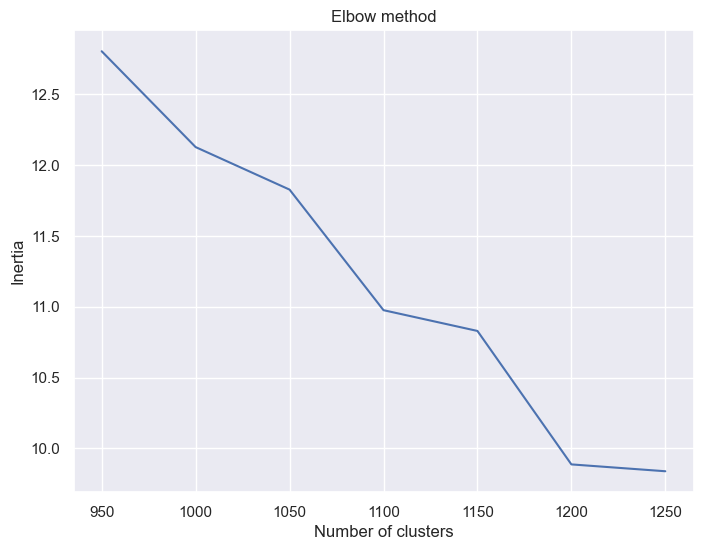

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(clusters, inertias)    
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method');

In [8]:
# Select the number of clusters
num_clusters = 1050

In [9]:
# Fit the centroids
kmeans = MiniBatchKMeans(n_clusters=num_clusters, 
                         init_size=3 * num_clusters,
                         n_init='auto',
                         random_state=seed).fit(customer_locs)

memberships = list(kmeans.labels_)
centroids = list(kmeans.cluster_centers_)

# Number of customers in each cluster
weights = list(np.histogram(memberships, bins=num_clusters)[0])

print('First cluster center:', centroids[0])
print('Weights for first 15 clusters:', weights[:15])

First cluster center: [-0.14704835  0.17163305]
Weights for first 15 clusters: [64, 65, 85, 57, 50, 88, 49, 53, 25, 62, 56, 69, 32, 30, 49]


In [10]:
#memberships

### Preprocessing: viable Customer-Store Pairings

Some facilities are just too far away from a cluster center to be relevant, so let's heuristically filter all distances that exceed a given `threshold`:

In [11]:
# Let's say this is the maximum distance in km
threshold = 0.95

In [12]:
def dist(loc1, loc2):
    """
    Euclidean distance:
        
        sqrt(sum(item_i ** 2))
    
    Args:
        loc1: (np.array)
            Point corresponding to the first location.
        loc2: (np.array)
            Point corresponding to the second location.
    """
    return np.linalg.norm(loc1 - loc2, ord=2)

pairings = {
    (facility, cluster): dist(facility_locs[facility], centroids[cluster])
    for facility in range(num_candidates)
        for cluster in range(num_clusters) 
            if  dist(facility_locs[facility], centroids[cluster]) < threshold
}
print("Number of viable pairings: {0}".format(len(pairings.keys())))

Number of viable pairings: 48723


###  Model Deployment

Build facilities from among candidate locations to minimize total distance to cluster centers:

In [13]:
import gurobipy as gp
from gurobipy import GRB

print(gp.gurobi.version())

(9, 5, 2)


class Model(builtins.object)
 |  Model(name='', env=None, cmodel=None)
 |  
 |  Gurobi model object.  Commonly used methods on this object are:
 |    getConstrs(): Get a list of constraints in the model
 |    getJSONSolution(): Get a JSON-string representation of the current solution(s) to the model
 |    getParamInfo(paramname): Get information on a model parameter.
 |    getVars(): Get a list of variables in the model
 |    optimize(): Optimize the model.
 |    printAttr(attrname, filter): Print attribute values.
 |    printQuality(): Print solution quality statistics.
 |    printStats(): Print model statistics.
 |    read(filename): Read model data (MIP start, basis, etc.) from a file
 |    reset(): Discard any resident solution information.
 |    resetParams(): Reset all parameters to their default values.
 |    setParam(paramname, newval): Set a model parameter to a new value.
 |    write(filename): Write model data to a file.
 |  
 |  Models have a number of attributes that can be queried or modified.
 |  For example, "print model.objval" prints the objective value of
 |  the current solution.  Commonly used model attributes are:
 |    numConstrs: Number of constraints in model
 |    numVars: Number of variables in model
 |    status: Optimization status
 |    objVal: Objective of current solution
 |  Type "help(GRB.attr)" for a complete list.
 |  
 |  Additional methods on this object are:
 |    addConstr(), addGenConstrMax(), addGenConstrMin(), addGenConstrAbs(),
 |    addGenConstrAnd(), addGenConstrOr(), addGenConstrNorm(),
 |    addGenConstrIndicator(), aaddGenConstrPWL(), addGenConstrPoly(),
 |    addGenConstrExp(), addGenConstrExpA(), addGenConstrLog(),
 |    addGenConstrLogA(), addGenConstrPow(), addGenConstrSin(),
 |    addGenConstrCos(), addGenConstrTan(), addRange(), addSOS(), addVar(),
 |    chgCoeff(), computeIIS(), copy(), fixed(), getCoeff(), getCol(), getRow(),
 |    message(), presolve(), relax(), terminate(), update()
 |  
 |  Additional help can be obtained on any of these methods (e.g.,
 |  help(Model.optimize)).
 |  
 |  Methods defined here:
 |  
 |  addConstr(self, lhs, sense=None, rhs=None, name='')
 |      ROUTINE:
 |        addConstr(tc, name)
 |      
 |      PURPOSE:
 |        Add a constraint to the model.
 |      
 |      ARGUMENTS:
 |        tc (TempConstr): The constraint to add
 |        name (string): Constraint name (default is no name)
 |      
 |      RETURN VALUE:
 |        Depending on the data of 'tc':
 |          - A Constr object if tc arose from a linear expression
 |          - A QConstr object if tc arose from a quadratic expression
 |          - An MConstr object if tc arose from a linear matrix expression
 |          - A GenConstr object if tc arose form a general constraint expression
 |      
 |      EXAMPLE:
 |        c = model.addConstr(x + y <= 1)
 |        c = model.addConstr(x + y + z == [1, 2])
 |        c = model.addConstr(x*x + y*y <= 1)
 |        c = model.addConstr(z == and_(y, x, w))
 |        c = model.addConstr(z == min_(x, y))
 |        c = model.addConstr((w == 1) >> (x + y <= 1))
 |        c = model.addConstr(A @ x <= b)
 |  
 |  addConstrs(self, constrs, name='')
 |      addConstrs(constrs, name="")
 |      
 |      Add constraints in bulk, using a generator expression.  Returns a dictionary
 |      of Constr objects, indexed by the values (or tuples of values) used by the
 |      generator expression.
 |      
 |      If you specify a name, the constraints will get that name.  If name is a scalar
 |      string, the names will be subscripted by the generator index.  If name
 |      equals the underscore character ("_"), then the names will equal the index value.
 |  
 |  addGenConstrAbs(self, resvar, argvar, name='')
 |      ROUTINE:
 |        addGenConstrAbs(resvar, argvar, name)
 |      
 |      PURPOSE:
 |        Add a general constraint of type ABS to the model.
 |      
 |      ARGUMENTS:
 |        resvar (Var): Resultant variable of ABS constraint
 |        argvar (Var): Argument variable of ABS constraint
 |        name (string): Constraint name (default is no name)
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrAbs(z, x1, "myAbsConstr")
 |  
 |  addGenConstrAnd(self, resvar, vars, name='')
 |      ROUTINE:
 |        addGenConstrAnd(resvar, vars, name)
 |      
 |      PURPOSE:
 |        Add a general constraint of type AND to the model.
 |      
 |      ARGUMENTS:
 |        resvar (Var): Resultant variable of AND constraint
 |        vars (list of Var, or tupledict): Argument variables of AND constraint
 |        name (string): Constraint name (default is no name)
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrAnd(z, [x1, x2, x3], "myAndConstr")
 |  
 |  addGenConstrCos(self, xvar, yvar, name='', options='')
 |      ROUTINE:
 |        addGenConstrCos(xvar, yvar, name, options)
 |      
 |      PURPOSE:
 |        Add a general constraint of type COS to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        name (string): Constraint name (default is no name)
 |        options (string): String to specify options for PWL approximiation
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrCos(x, y)
 |  
 |  addGenConstrExp(self, xvar, yvar, name='', options='')
 |      ROUTINE:
 |        addGenConstrExp(xvar, yvar, name, options)
 |      
 |      PURPOSE:
 |        Add a general constraint of type EXP to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        name (string): Constraint name (default is no name)
 |        options (string): String to specify options for PWL approximiation
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrExp(x, y)
 |  
 |  addGenConstrExpA(self, xvar, yvar, a, name='', options='')
 |      ROUTINE:
 |        addGenConstrExpA(xvar, yvar, a, name, options)
 |      
 |      PURPOSE:
 |        Add a general constraint of type EXPA to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        a (float): Base of exponential function
 |        name (string): Constraint name (default is no name)
 |        options (string): String to specify options for PWL approximiation
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrExpA(x, y, 3)
 |  
 |  addGenConstrIndicator(self, binvar, binval, lhs, sense=None, rhs=None, name='')
 |      ROUTINE:
 |        addGenConstrIndicator(binvar, binval, lhs, sense, rhs, name)
 |      
 |      PURPOSE:
 |        Add a general constraint of type INDICATOR to the model.
 |      
 |      ARGUMENTS:
 |        GRB.GENCONSTR_INDICATOR (option 1):
 |          binvar (Var): Antecedent variable of indicator constraint
 |          binval (bool): Value of antecedent variable that activates the linear constraint
 |          lhs (float, Var, or LinExpr): Linear expression of constraint triggered by the indicator
 |          sense (str): Sense of constraint triggered by the indicator (e.g., GRB.LESS_EQUAL)
 |          rhs (float): Right-hand side of linear constraint triggered by the indicator
 |          name (string): Constraint name (default is no name)
 |      
 |        GRB.GENCONSTR_INDICATOR (option 2):
 |          binvar (Var): Antecedent variable of indicator constraint
 |          binval (bool): Value of antecedent variable that activates the linear constraint
 |          lhs (TempConstr): Linear constraint triggered by indicator
 |          name (string): Constraint name (default is no name)
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrIndicator(z, 0, 2*x1 - 1.5*x2 + 3.0*x3 == 4.5, name="myIndicatorConstr")
 |  
 |  addGenConstrLog(self, xvar, yvar, name='', options='')
 |      ROUTINE:
 |        addGenConstrLog(xvar, yvar, name, options)
 |      
 |      PURPOSE:
 |        Add a general constraint of type LOG to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        name (string): Constraint name (default is no name)
 |        options (string): String to specify options for PWL approximiation
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrLog(x, y)
 |  
 |  
 |  addGenConstrPWL(self, xvar, yvar, xpts, ypts, name='')
 |      ROUTINE:
 |        addGenConstrPWL(xvar, yvar, xpts, ypts, name)
 |      
 |      PURPOSE:
 |        Add a general constraint of type PWL to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        xpts (list of float): x coordinates for the breakpoints
 |        ypts (list of float): y coordinates for the breakpoints
 |        name (string): Constraint name (default is no name)
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrPWL(x, y, [0, 1, 2], [1.5, 0, 3], "myPWLConstr")
 |  
 |  
 |  addGenConstrPow(self, xvar, yvar, a, name='', options='')
 |      ROUTINE:
 |        addGenConstrPow(xvar, yvar, a, name, options)
 |      
 |      PURPOSE:
 |        Add a general constraint of type POW to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        a (float): The exponent of the function
 |        name (string): Constraint name (default is no name)
 |        options (string): String to specify options for PWL approximiation
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrPow(x, y, 2)
 |  
 |  addGenConstrSin(self, xvar, yvar, name='', options='')
 |      ROUTINE:
 |        addGenConstrSin(xvar, yvar, name, options)
 |      
 |      PURPOSE:
 |        Add a general constraint of type SIN to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        name (string): Constraint name (default is no name)
 |        options (string): String to specify options for PWL approximiation
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrSin(x, y)
 |  
 |  addGenConstrTan(self, xvar, yvar, name='', options='')
 |      ROUTINE:
 |        addGenConstrTan(xvar, yvar, name, options)
 |      
 |      PURPOSE:
 |        Add a general constraint of type TAN to the model.
 |      
 |      ARGUMENTS:
 |        xvar (Var): x variable for constraint
 |        yvar (Var): y variable for constraint
 |        name (string): Constraint name (default is no name)
 |        options (string): String to specify options for PWL approximiation
 |      
 |      RETURN VALUE:
 |        The created general constraint object.
 |      
 |      EXAMPLE:
 |        genconstr = model.addGenConstrTan(x, y)
 |  
 |  addLConstr(self, lhs, sense=None, rhs=None, name='')
 |      ROUTINE:
 |        addLConstr(lhs, sense, rhs, name)
 |      
 |      PURPOSE:
 |        Add a linear constraint to the model.
 |      
 |      ARGUMENTS:
 |        lhs (float, Var, LinExpr or TempConstr): Left-hand side
 |        sense (str): Constraint sense (e.g., GRB.LESS_EQUAL)
 |        rhs (float, Var, or LinExpr): Right-hand side
 |        name (string): Constraint name (default is no name)
 |      
 |      RETURN VALUE:
 |        The created Constr object.
 |      
 |      EXAMPLE:
 |        c = model.addLConstr(x + y <= 1)
 |        c = model.addLConstr(LinExpr([1.0,1.0], [x,y]), GRB.LESS_EQUAL, 1)
 |        c = model.addLConstr(lhs = 5 * x + y, sense = GRB.LESS_EQUAL, rhs = 3 * z, name = "C1")
 |  
 |  
 |  addMVar(self, shape, lb=None, ub=None, obj=None, vtype=None, name=None)
 |      ROUTINE:
 |        addMVar(shape, lb=0, ub=GRB.INFINITY, obj=0.0, vtype=GRB.CONTINUOUS,
 |                name="")
 |      
 |      PURPOSE:
 |        Add a matrix variable (MVar object) to the model.
 |      
 |      ARGUMENTS:
 |        shape (tuple): Dimensions of the variable (like NumPy ndarray shape)
 |        lb (float): Lower bound (default is zero)
 |        ub (float): Upper bound (default is infinite)
 |        obj (float): Objective coefficient (default is zero)
 |        vtype (string): Variable type (default is continuous)
 |        name (string): Variable name (default is no name)
 |      
 |        The values of the lb, ub, obj, vtype and name arguments can either
 |        be scalars, or lists of length equal to the number of elements in the MVar.
 |      
 |      RETURN VALUE:
 |        The created MVar object.
 |      
 |      EXAMPLE:
 |        # Add a 4-by-2 matrix binary variable
 |        x = model.addMVar((4,2), vtype=GRB.BINARY)
 |        # Add a vector of three variables with non-default lower bounds
 |        y = model.addMVar((3,), lb=[-1, -2, -1])
 |  
 |  
 |  
 |  addVar(self, lb=0.0, ub=1e+100, obj=0.0, vtype='C', name='', column=None)
 |      ROUTINE:
 |        addVar(lb, ub, obj, vtype, name, column)
 |      
 |      PURPOSE:
 |        Add a variable to the model.
 |      
 |      ARGUMENTS:
 |        lb (float): Lower bound (default is zero)
 |        ub (float): Upper bound (default is infinite)
 |        obj (float): Objective coefficient (default is zero)
 |        vtype (string): Variable type (default is GRB.CONTINUOUS)
 |        name (string): Variable name (default is no name)
 |        column (Column): Initial coefficients for column (default is None)
 |      
 |      RETURN VALUE:
 |        The created Var object.
 |      
 |      EXAMPLE:
 |        v = model.addVar(ub=2.0, name="NewVar")
 |  
 |  addVars(self, *indexes, **kwargs)
 |      addVars(*indexes, lb=0.0, ub=GRB.INFINITY, obj=0.0, vtype=GRB.CONTINUOUS,
 |                 name="")
 |      
 |      Add variables in bulk, given one or more lists or integers that serve as
 |      indexes for the variables.  Returns a dictionary of Var objects, indexed by
 |      the values (or tuples of values) from the index set.
 |      
 |      The optional parameters (lb, ub, obj, vtype, name) work similar
 |      to the addVar() method, with the following exceptions:
 |      1. The parameter name is required (ex: vtype=GRB.BINARY)
 |      2. You can specify the value as a scalar, a list or a dictionary.  For a scalar,
 |         the value will be used for all variables; for a list, the values must be
 |         in the same order as the index set; for a dictionary, they must be indexed
 |         by the variable index.
 |      3. If you specify a scalar string for name, the variable name will be
 |         subscripted automatically.
 |  
 |  
 |  close(self)
 |      ROUTINE:
 |        close()
 |      
 |      Synonymous to Model.dispose().
 |  
 |  
 |  copy(self)
 |      ROUTINE:
 |        copy()
 |      
 |      PURPOSE:
 |        Create an exact copy of a model.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        The copied Model object.
 |      
 |      EXAMPLE:
 |        copy = model.copy()
 |        copy.optimize()
 | 
 |  
 |  
 |  dualize(self)
 |      ROUTINE:
 |        dualize()
 |      
 |      PURPOSE:
 |        Return the dual version of the model.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        A new model, containing the dual version of the original model.
 |      
 |      EXAMPLE:
 |        dual = model.dualize()
 |        dual.optimize()
 |  feasibility(self)
 |      ROUTINE:
 |        feasibility()
 |      
 |      PURPOSE:
 |        Return the feasibility version of the MIP model.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        A copy of the given model with a cancelled objective function.
 |      
 |      EXAMPLE:
 |        feasibility = model.feasibility()
 |        feasibility.optimize()
 |  
 |  getAttr(self, attrname, objs=None)
 |      ROUTINE:
 |        getAttr(attrname), or
 |        getAttr(attrname, objs)
 |      
 |      PURPOSE:
 |        Request the value of an attribute.
 |      
 |      ARGUMENTS:
 |        attrname (string): The name of the requested attribute.
 |        objs (optional): List or dictionary of variables or constraints.
 |      
 |      RETURN VALUE:
 |        The attribute value. If argument 'objs' is present, a list of
 |        values is returned.
 |      
 |      EXAMPLE:
 |        print(model.getAttr("modelName"))
 |        print(model.getAttr("lb", model.getVars()))
 |        print(model.getAttr("qcrhs", model.getQConstrs()))
 |      
 |      NOTES:
 |        Type "help(GRB.attr)" for a list of all available attributes.
 |  
 |  getCoeff(self, constr, var)
 |      ROUTINE:
 |        getCoeff(constr, var)
 |      
 |      PURPOSE:
 |        Retrieve a coefficient from the constraint matrix.
 |      
 |      ARGUMENTS:
 |        constr (Constr): Constraint of interest
 |        var (Var): Variable of interest
 |      
 |      RETURN VALUE:
 |        The coefficient for 'var' in 'constr'
 |      
 |      EXAMPLE:
 |        coeff = model.getCoeff(model.getConstrs()[0], model.getVars()[0])
 |  
 |  
 |  
 |  getConstrByName(self, name)
 |      ROUTINE:
 |        getConstrByName(name)
 |      
 |      PURPOSE:
 |        Retrieve a linear constraint with the specified name from the model.
 |      
 |      ARGUMENTS:
 |        Constraint name.
 |      
 |      RETURN VALUE:
 |        A Constr object, or None if no matching variable is found.
 |      
 |      EXAMPLE:
 |        constr = model.getConstrByName("c1")
 |  
 |  getConstrs(self)
 |      ROUTINE:
 |        getConstrs()
 |      
 |      PURPOSE:
 |        Obtain a list of linear constraints in the model.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        A list of Constr objects.
 |      
 |      EXAMPLE:
 |        constrs = model.getConstrs()
 |        for c in constrs:
 |          print(c.ConstrName, c.Slack)
 |  
 |  getGenConstrAbs(self, genconstr)
 |      ROUTINE:
 |        getGenConstrAbs(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type ABS.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type ABS whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (resvar, argvar) that contains the data associated
 |        with the general constraint:
 |          resvar (Var): Resultant variable of ABS constraint
 |          argvar (Var): Argument variable of ABS constraint
 |      
 |      EXAMPLE:
 |        (resvar, argvar) = model.getGenConstrAbs(model.getGenConstrs()[0])
 |  
 |  getGenConstrAnd(self, genconstr)
 |      ROUTINE:
 |        getGenConstrAnd(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type AND.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type AND whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (resvar, vars) that contains the data associated
 |        with the general constraint:
 |          resvar (Var): Resultant variable of AND constraint
 |          vars (list of Var): Operand variables of AND constraint
 |      
 |      EXAMPLE:
 |        (resvar, vars) = model.getGenConstrAnd(model.getGenConstrs()[0])
 |  
 |  getGenConstrCos(self, genconstr)
 |      ROUTINE:
 |        getGenConstrCos(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type COS.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type COS whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (xvar, yvar) that contains the data associated with
 |        the general constraint:
 |          xvar (Var): x variable for constraint
 |          yvar (Var): y variable for constraint
 |      
 |      EXAMPLE:
 |        (xvar, yvar) = model.getGenConstrCos(model.getGenConstrs()[0])
 |  
 |  getGenConstrExp(self, genconstr)
 |      ROUTINE:
 |        getGenConstrExp(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type EXP.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type EXP whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (xvar, yvar) that contains the data associated with
 |        the general constraint:
 |          xvar (Var): x variable for constraint
 |          yvar (Var): y variable for constraint
 |      
 |      EXAMPLE:
 |        (xvar, yvar) = model.getGenConstrExp(model.getGenConstrs()[0])
 |  
 |  getGenConstrExpA(self, genconstr)
 |      ROUTINE:
 |        getGenConstrExpA(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type EXPA.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type EXPA whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (xvar, yvar, a) that contains the data associated
 |        with the general constraint:
 |          xvar (Var): x variable for constraint
 |          yvar (Var): y variable for constraint
 |          a (float): Base of exponential function
 |      
 |      EXAMPLE:
 |        (xvar, yvar, a) = model.getGenConstrExp(model.getGenConstrs()[0])
 |  
 |  getGenConstrIndicator(self, genconstr)
 |      ROUTINE:
 |        getGenConstrIndicator(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type INDICATOR.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type INDICATOR whose
 |                               data is being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (binvar, binval, vars, vals, sense, rhs) that contains
 |        the data associated with the general constraint:
 |          binvar (Var): Antecedent variable of indicator constraint
 |          binval (bool): Value of antecedent variable that activates the linear constraint
 |          expr (LinExpr): LinExpr object containing the left-hand side of the constraint triggered by the indicator
 |          sense (str): Sense of linear constraint triggered by the indicator (e.g., GRB.LESS_EQUAL)
 |          rhs (float): Right-hand side of linear constraint triggered by the indicator
 |      
 |      EXAMPLE:
 |        (binvar, binval, expr, sense, rhs) = model.getGenConstr(model.getGenConstrs()[0])
 |  
 |  getGenConstrLog(self, genconstr)
 |      ROUTINE:
 |        getGenConstrLog(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type LOG.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type LOG whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (xvar, yvar) that contains the data associated with
 |        the general constraint:
 |          xvar (Var): x variable for constraint
 |          yvar (Var): y variable for constraint
 |      
 |      EXAMPLE:
 |        (xvar, yvar) = model.getGenConstrLog(model.getGenConstrs()[0])
 |  
 |  
 |  getGenConstrPow(self, genconstr)
 |      ROUTINE:
 |        getGenConstrPow(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type POW.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type POW whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (xvar, yvar, a) that contains the data associated
 |        with the general constraint:
 |          xvar (Var): x variable for constraint
 |          yvar (Var): y variable for constraint
 |          a (float): The exponent of the function
 |      
 |      EXAMPLE:
 |        (xvar, yvar, a) = model.getGenConstrLog(model.getGenConstrs()[0])
 |  
 |  getGenConstrSin(self, genconstr)
 |      ROUTINE:
 |        getGenConstrSin(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type SIN.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type SIN whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (xvar, yvar) that contains the data associated with
 |        the general constraint:
 |          xvar (Var): x variable for constraint
 |          yvar (Var): y variable for constraint
 |      
 |      EXAMPLE:
 |        (xvar, yvar) = model.getGenConstrSin(model.getGenConstrs()[0])
 |  
 |  getGenConstrTan(self, genconstr)
 |      ROUTINE:
 |        getGenConstrTan(genconstr)
 |      
 |      PURPOSE:
 |        Obtain all data associated with a general constraint of type TAN.
 |      
 |      ARGUMENTS:
 |        genconstr (GenConstr): The general constraint of type TAN whose data is
 |                               being queried.
 |      
 |      RETURN VALUE:
 |        A tuple (xvar, yvar) that contains the data associated with
 |        the general constraint:
 |          xvar (Var): x variable for constraint
 |          yvar (Var): y variable for constraint
 |      
 |      EXAMPLE:
 |        (xvar, yvar) = model.getGenConstrTan(model.getGenConstrs()[0])
 |  
 |  
 |  getObjective(self, index=None)
 |      ROUTINE:
 |        getObjective()
 |      
 |      PURPOSE:
 |        Query the model objective
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        Model objective function, returned as either a LinExpr or QuadExpr
 |        object.
 |      
 |      EXAMPLE:
 |        expr = model.getObjective()
 |  
 |  getPWLObj(self, var)
 |      ROUTINE:
 |        getPWLObj(var)
 |      
 |      PURPOSE:
 |        Retrieves the piecewise-linear objective for a variable
 |      
 |      ARGUMENTS:
 |        var: the Var whose piecewise objective is returned.
 |      
 |      RETURN VALUE:
 |        A list of tuples, where each tuple captures a point on
 |        the piecewise-linear function.
 |      
 |      EXAMPLE:
 |        print(model.getPWLObj(v))
 |  
 |  getParamInfo(self, paramname)
 |      ROUTINE:
 |        getParamInfo(paramname)
 |      
 |      PURPOSE:
 |        Get information about a parameter.
 |      
 |      ARGUMENTS:
 |        paramname (string): The name of the parameter.
 |      
 |      RETURN VALUE:
 |        A tuple containing the parameter name, the parameter type, the
 |        current value, the minimum allowed value, the maximum allowed value,
 |        and the default value.
 |      
 |      EXAMPLE:
 |        model.getParamInfo("NodeLimit")
 |      
 |      NOTES:
 |        Routine paramHelp() provides additional information on the available
 |        parameters.
 |  
 |  getRow(self, constr)
 |      ROUTINE:
 |        getRow(constr)
 |      
 |      PURPOSE:
 |        Obtain all terms associated with a constraint.
 |      
 |      ARGUMENTS:
 |        constr (Constr): The constraint whose terms are being queried.
 |      
 |      RETURN VALUE:
 |        A LinExpr object containing the left-hand side of the constraint.
 |      
 |      EXAMPLE:
 |        expr = model.getRow(model.getConstrs()[0])
 |        for i in range(expr.size()):
 |          print(expr.getCoeff(i), expr.getVar(i))
 | 
 |  
 |  getTuneResult(self, i)
 |      ROUTINE:
 |        getTuneResult(i)
 |      
 |      PURPOSE:
 |        Retrieve tuned parameter settings.
 |      
 |      ARGUMENTS:
 |        Tuning result number.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.getTuneResult(0)
 |  
 |  getVarByName(self, name)
 |      ROUTINE:
 |        getVarByName(name)
 |      
 |      PURPOSE:
 |        Retrieve a variable with the specified name from the model.
 |      
 |      ARGUMENTS:
 |        Variable name.
 |      
 |      RETURN VALUE:
 |        A Var object, or None if no matching variable is found.
 |      
 |      EXAMPLE:
 |        var = model.getVarByName("x1")
 |  
 |  getVars(self)
 |      ROUTINE:
 |        getVars()
 |      
 |      PURPOSE:
 |        Obtain a list of variables in the model.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        A list of Var objects.
 |      
 |      EXAMPLE:
 |        allvars = model.getVars()
 |        for v in allvars:
 |          print(v.VarName, v.X)
 |  
 |  
 |  optimize(self, callback=None)
 |      ROUTINE:
 |        optimize()
 |      
 |      PURPOSE:
 |        Optimize the model.
 |      
 |      ARGUMENTS:
 |        callback (function, optional): Callback function which takes two
 |                 arguments, model and where.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.optimize()
 |      
 |      NOTES:
 |        The algorithm used to optimize the model depends on the model type and
 |        on the parameter settings.  A MIP model will always be optimized using
 |        the branch-and-cut algorithm.  A continuous model will be optimized
 |        using the dual simplex algorithm by default; the Method parameter
 |        can be used to choose a different algorithm.
 |  
 |  presolve(self)
 |      ROUTINE:
 |        presolve()
 |      
 |      PURPOSE:
 |        Return the presolved version of the model.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        A new model, containing the presolved version of the original model.
 |      
 |      EXAMPLE:
 |        presolved = model.presolve()
 |        presolved.optimize()
 |  
 |  printAttr(self, attrname, filter='*')
 |      ROUTINE:
 |        printAttr(attrname, filter)
 |      
 |      PURPOSE:
 |        Print model attribute data.
 |      
 |      ARGUMENTS:
 |        attrname (string): The name of the attribute to print.  For attributes
 |                           with numerical values, only non-zero entries will
 |                           be printed.  Can be a list of attribute names,
 |                           in which case all listed attributes will be printed.
 |        filter (string): Regular expression for filtering results.   Only
 |                         variables/constraints whose names match the
 |                         (optional) filter are printed.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.optimize()
 |        model.printAttr("x", "v*")     # print 'x' when var name begins with 'v'
 |        model.printAttr(["lb", "ub"])  # print 'lb' and 'ub' attribute values
 |  
 |  printQuality(self)
 |      ROUTINE:
 |        printQuality()
 |      
 |      PURPOSE:
 |        Print solution quality statistics.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.optimize()
 |        model.printQuality()
 |  
 |  printStats(self)
 |      ROUTINE:
 |        printStats()
 |      
 |      PURPOSE:
 |        Print model statistics.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.printStats()
 |  
 |  read(self, filename)
 |      ROUTINE:
 |        read(filename)
 |      
 |      PURPOSE:
 |        Import model data from a file.  The type of data is determined by
 |        the file suffix: .mst for MIP start data, .bas for basis
 |        information, or .prm for parameter settings.
 |      
 |      ARGUMENTS:
 |        filename (string): The name of the file.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.read("start.mst")
 |      
 |      NOTES:
 |        The file name may contain the '*' and '?' wildcard characters.  If
 |        more than one file matches, this routine will read the first match.
 |  
 |  relax(self)
 |      ROUTINE:
 |        relax()
 |      
 |      PURPOSE:
 |        Return the relaxed version of the MIP model, in which all integrality
 |        restrictions, SOS conditions, semi-continuous and semi-integer
 |        requirements on variables have been relaxed and general constraints
 |        have been removed.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        A new, relaxed model.
 |      
 |      EXAMPLE:
 |        relaxed = model.relax()
 |        relaxed.optimize()
 |      
 |      NOTES:
 |        If the model is already continuous, then this method produces the
 |        same result as cloning the model.
 |  
 |  remove(self, items)
 |      ROUTINE:
 |        remove(items)
 |      
 |      PURPOSE:
 |        Remove variables, linear constraints, SOS constraints, quadratic
 |        constraints, or general constraints from the model.
 |      
 |      ARGUMENTS:
 |        items: Items to remove from model.  The argument can be
 |               a single Constr, MConstr, Var, MVar, SOS, QConstr, or GenConstr,
 |               or it can be a list, tuple, or dict containing
 |               such items.  For a dict, the dict values will be
 |               removed, not the keys.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.remove(model.getVars()[0])
 |        model.remove(model.getConstrs()[0:10])
 |  
 |  reset(self, clearall=0)
 |      ROUTINE:
 |        reset()
 |      
 |      PURPOSE:
 |        Discard any solution information.  The next optimize() call starts
 |        from scratch.
 |      
 |      ARGUMENTS:
 |        clearall (int, optional): Should additional information such as MIP
 |                 starts, variable hints, branching priorities, lazy flags,
 |                 and partition information be cleared?
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.reset()
 |  
 |  resetParams(self)
 |      ROUTINE:
 |        resetParams()
 |      
 |      PURPOSE:
 |        Reset all parameters to their default values.
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.resetParams()
 |  
 |  setAttr(self, attrname, arg1, arg2=None)
 |      ROUTINE:
 |        setAttr(attrname, newvalue), or
 |        setAttr(attrname, objects, newvalues)
 |      
 |      PURPOSE:
 |        Change the value(s) of an attribute.
 |      
 |      ARGUMENTS:
 |        attrname (string): The name of the requested attribute.
 |        objects(optional): A list of variables or constraints.
 |        newvalue: The desired new value.  The type of the value should be
 |                  compatible with the attribute type (e.g., an integer parameter
 |                  will take an integer value).
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.setAttr("modelSense", -1)
 |        model.setAttr("lb", [x, y, z], [1, 1, 1])
 |      
 |      NOTES:
 |        Model attributes that can be set are:
 |          modelName:  Model name.
 |          modelSense: Objective sense.
 |      
 |        Attributes changes are handled in a lazy fashion.  The effect of a
 |        change isn't visible until after the next call to Model.update() or
 |        Model.optimize().
 |  
 |  setMObjective(self, Q, c, constant, xQ_L=None, xQ_R=None, xc=None, sense=None)
 |      ROUTINE:
 |        setMObjective(Q, c, constant, xQ_L=None, xQ_R=None, xc=None, sense=None)
 |      
 |      PURPOSE:
 |        Set the objective function using matrix semantics.  The new objective
 |        is 'xQ_L' Q xQ_R + c' xc + constant'.
 |      
 |      ARGUMENTS:
 |      
 |        Q (NumPy or SciPy.sparse matrix, or None): Quadratic objective matrix
 |        c (1-D NumPy array, or None): Linear objective vector
 |        constant (float): Objective constant
 |        xQ_L, xQ_R, xc (MVar, or a list of Var, or None): Vector of Gurobi
 |           variables.  A 'None' argument uses all variables in the model.
 |        sense (optional): Objective sense.  By default, this method uses the
 |              modelSense model attribute to determine the sense.  Use
 |              GRB.MINIMIZE or GRB.MAXIMIZE to ignore modelSense and pick a
 |              specific sense.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        Q = numpy.full((2, 3), 1.0)
 |        xL = model.addMVar(2)
 |        xR = model.addMVar(3)
 |        model.setMObjective(Q, None, 0.0, xL, xR, None)
 |  
 |  setObjective(self, expr, sense=None)
 |      ROUTINE:
 |        setObjective(expr, sense=None)
 |      
 |      PURPOSE:
 |        Set the model objective equal to a LinExpr or QuadExpr
 |      
 |      ARGUMENTS:
 |        expr: The desired objective function.  The objective can be
 |              a linear expression (LinExpr) or a quadratic expression (QuadExpr).
 |              This routine will replace the 'Obj' attribute on model variables
 |              with the corresponding values from the supplied expression.
 |        sense (optional): Objective sense.  By default, this method uses the
 |              modelSense model attribute to determine the sense.  Use
 |              GRB.MINIMIZE or GRB.MAXIMIZE to ignore modelSense and pick a
 |              specific sense.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.setObjective(x + y)
 |        model.setObjective(x + y + 2*z, GRB.MAXIMIZE)
 |  
 |  setParam(self, paramname, newval)
 |      ROUTINE:
 |        setParam(paramname, newval)
 |      
 |      PURPOSE:
 |        Set a parameter to a new value.
 |      
 |      ARGUMENTS:
 |        paramname (string): The name of the parameter.
 |        newval: The desired new value.  The type of the value should be
 |                compatible with the parameter type (e.g., an integer
 |                parameter will take an integer value).  One important
 |                exception: the string "default" will return the specified
 |                parameter to its default value.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.setParam("NodeLimit", 100)
 |        model.setParam("TimeLimit", "default")
 |      
 |      NOTES:
 |        Use this routine to change parameter values in the default environment.
 |        The default environment is used to initialize parameter values when a
 |        new model is created.  Once the model exists, changes to the default
 |        environment will no longer affect that model.  Use Model.setParam()
 |        to change parameter settings for an existing model.
 |      
 |        Routine paramHelp() provides additional information on the available
 |        parameters.
 |  
 |  tune(self)
 |      ROUTINE:
 |        tune()
 |      
 |      PURPOSE:
 |        Tune parameter settings
 |      
 |      ARGUMENTS:
 |        None.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.tune()
 |  
 |  
 |  write(self, filename)
 |      ROUTINE:
 |        write(filename)
 |      
 |      PURPOSE:
 |        Write model data to a file.  The type of data is determined by the
 |        file suffix: .lp or .mps to write the model itself, .mst to write
 |        the current solution as a MIP start, .bas to write the current
 |        simplex basis, or .prm to write the modified parameters.
 |      
 |      ARGUMENTS:
 |        filename (string): The name of the file to write.
 |      
 |      RETURN VALUE:
 |        None.
 |      
 |      EXAMPLE:
 |        model.write("model.lp")
 |        model.write("model.mst")

In [34]:
# help(gp.Model)

In [14]:
def make_model(n_candidates, n_clusters, pairs, weights):
    """
    Helper for making models.
    """
    m = gp.Model("Facility location")

    # Decision variables: select facility locations
    select = m.addVars(range(n_candidates), vtype=GRB.BINARY, name='select')
    # Decision variables: assign customer clusters to a facility location
    assign = m.addVars(pairs.keys(), vtype=GRB.BINARY, name='assign')

    # Deploy Objective Function
    # 0. Total distance
    obj = gp.quicksum(weights[cluster] * pairs[facility, cluster] * assign[facility, cluster]
                      for facility, cluster in pairs.keys())
    m.setObjective(obj, GRB.MINIMIZE)

    # 1. Facility limit
    m.addConstr(select.sum() <= max_facilities, name="Facility_limit")

    # 2. Open to assign
    m.addConstrs((assign[facility, cluster] <= select[facility]
                  for facility, cluster in pairs.keys()),
                 name="Open2assign")

    # 3. Closest store
    m.addConstrs((assign.sum('*', cluster) == 1
                  for cluster in range(n_clusters)),
                 name="Closest_store")
    #
    return m, select, assign

In [15]:
m, select, assign = make_model(num_candidates, num_clusters, pairings, weights)

# Find the optimal solution
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-11
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 49774 rows, 48773 columns and 146219 nonzeros
Model fingerprint: 0x10b5649b
Variable types: 0 continuous, 48773 integer (48773 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve time: 0.22s
Presolved: 49774 rows, 48773 columns, 146219 nonzeros
Variable types: 0 continuous, 48773 integer (48773 binary)
Found heuristic solution: objective 15873.436365

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root relaxation: objective 7.518990e+03, 8482 iterations, 1.30 seconds (1.58 work units)

    Nodes    |    Current Node    |  

## Analysis

Let's plot a map with:

- Customer locations represented as small pink dots.
- Customer cluster centroids represented as large red dots.
- Facility location candidates represented as green diamonds. Notice that selected locations have black lines emanating from them towards each cluster that is likely to be served by that facility.

In [16]:
print(f'Number of selected locations:', sum([v.x for v in select.values()]))

for i, v in enumerate(select.values()):
    if v.x > 0.5:
        print(f"Location {i}({facility_locs[i][0]:6.3f}, {facility_locs[i][1]:6.3f}) has been selected.")

Number of selected locations: 6.0
Location 18(-0.444, -0.207) has been selected.
Location 26(-0.105,  0.388) has been selected.
Location 36( 0.360, -0.299) has been selected.
Location 37(-0.072, -0.239) has been selected.
Location 40( 0.313,  0.435) has been selected.
Location 44( 0.311,  0.165) has been selected.


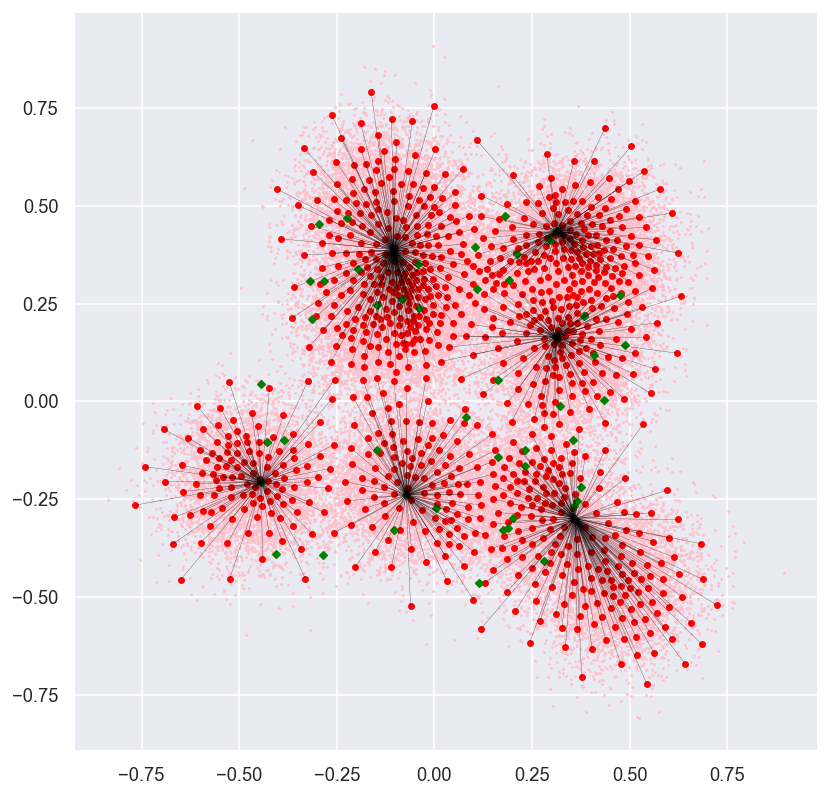

In [ ]:
plt.figure(figsize=(8,8), dpi=120)
plt.scatter(*zip(*customer_locs), c='Pink', s=0.5)
plt.scatter(*zip(*centroids), c='Red', s=10)
plt.scatter(*zip(*facility_locs), c='Green', marker='D', s=10)

assignments = [p for p in pairings if assign[p].x > 0.5]
for p in assignments:
    pts = [facility_locs[p[0]], centroids[p[1]]]
    plt.plot(*zip(*pts), c='Black', linewidth=0.15)

In [18]:
def compute_distance(assignment, f_locs, c_locs, cluster_labels):
    """
    Compute true distance (without the cluster weighting factor).
    
    Args:
        assignment: 
            Facility assigned to each cluster.
        f_locs: (list of tuples)
            Facilities locations.
        c_locs: (list of tuples)
            Customers locations.
        cluster_assign:
            Cluster label assigned to each customer.
    """
    _f_locs = np.array(f_locs)
    _c_locs = np.array(c_locs)
    distance = 0
    for facility_idx, cluster_idx in assignment:
        # Take the true customer locations
        locs = _c_locs[cluster_labels == cluster_idx]

        # Compute the true distance between the customer and the facility
        distance += np.linalg.norm(locs - _f_locs[facility_idx], axis=1).sum()
        
    return distance

In [19]:
distance = compute_distance(assignments, facility_locs, customer_locs, kmeans.labels_)

# Objective function
print(f'Sum of the distances from customers and assigned facility: {distance:.3f}')

Sum of the distances from customers and assigned facility: 7566.314


### Sensitivity to threshold

If we change the threshold for making pairs, what's happen?

In [20]:
from time import time

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
output = {}

for th in thresholds:
    print(f"Running threshold {th} ...")
    
    # Make the pairs
    pairings = {
        (facility, cluster): dist(facility_locs[facility], centroids[cluster])
        for facility in range(num_candidates)
            for cluster in range(num_clusters) 
                if  dist(facility_locs[facility], centroids[cluster]) < th
    }
    
    # Make the model
    m, select, assign = make_model(num_candidates, num_clusters, pairings, weights)
    
    # Find the optimal solution
    m.setParam('OutputFlag', 0)
    st = time()
    m.optimize()
    print(f"\tIt took {time()-st:.3f} sec.")
    
    # Compute true obj
    a = [p for p in pairings if assign[p].x > 0.5]
    d = compute_distance(a, facility_locs, customer_locs, kmeans.labels_)
    
    # Save
    output[th] = d

Running threshold 0.5 ...
	It took 1.072 sec.
Running threshold 0.6 ...
	It took 1.147 sec.
Running threshold 0.7 ...
	It took 1.566 sec.
Running threshold 0.8 ...
	It took 1.612 sec.
Running threshold 0.9 ...
	It took 1.832 sec.
Running threshold 1.0 ...
	It took 1.687 sec.
Running threshold 1.1 ...
	It took 2.465 sec.
Running threshold 1.2 ...
	It took 2.325 sec.
Running threshold 1.3 ...
	It took 2.134 sec.
Running threshold 1.4 ...
	It took 2.325 sec.
Running threshold 1.5 ...
	It took 1.996 sec.


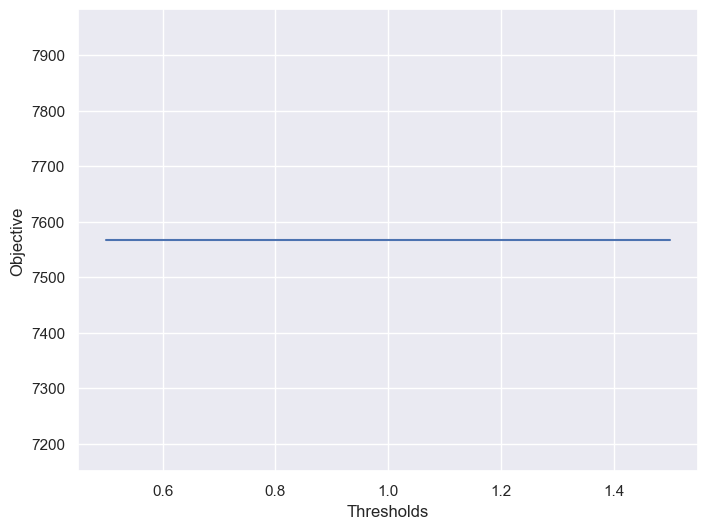

In [21]:
plt.figure(figsize=(8, 6))
#
plt.plot(thresholds, [output[t] for t in thresholds])
#
plt.ylabel('Objective')
plt.xlabel('Thresholds')
plt.show()

### Without Clustering

**Objective Function**:

- **Total distance**: Minimize the total distance from customers to their assigned facility:

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Pairings}} \text{dist}_{i,j} \cdot \text{assign}_{i,j}
\tag{0}
\end{equation}


**Constraints**:

- **Facility limit**: The number of facilities cannot exceed the limit:

\begin{equation}
\sum_{j}\text{select}_j \leq \text{max_facilities}
\tag{1}
\end{equation}

- **Open to assign**: Customer $i$ can only be assigned to facility $j$ if we decide to build that facility:

\begin{equation}
\text{assign}_{i,j} \leq \text{select}_{j} \quad \forall (i,j) \in \text{Pairings}
\tag{2}
\end{equation}

- **Closest store**: Customer $i$ must be assigned to exactly one facility:

\begin{equation}
\sum_{j:(i,j) \in \text{Pairings}}\text{assign}_{i,j} = 1 \quad \forall i \in I
\tag{3}
\end{equation}

In [22]:
customer_locs_a = np.array(customer_locs)

pairings = {
    (facility, customer): dist(facility_locs[facility], customer_locs_a[customer])
    for facility in range(num_candidates)
        for customer in range(num_customers) 
            if  dist(facility_locs[facility], customer_locs_a[customer]) < threshold
}
print("Number of viable pairings: {0}".format(len(pairings.keys())))

Number of viable pairings: 2332341


In [23]:
m = gp.Model("Facility location")

# Decision variables: select facility locations
select = m.addVars(range(num_candidates), vtype=GRB.BINARY, name='select')
# Decision variables: assign customer clusters to a facility location
assign = m.addVars(pairings.keys(), vtype=GRB.BINARY, name='assign')

# Deploy Objective Function
# 0. Total distance
obj = gp.quicksum(pairings[facility, customer] * assign[facility, customer]
                  for facility, customer in pairings.keys())
m.setObjective(obj, GRB.MINIMIZE)

# 1. Facility limit
m.addConstr(select.sum() <= max_facilities, name="Facility_limit")

# 2. Open to assign
m.addConstrs((assign[facility, cluster] <= select[facility]
              for facility, cluster in pairings.keys()),
             name="Open2assign")

# 3. Closest store
m.addConstrs((assign.sum('*', customer) == 1
              for customer in range(num_customers)),
             name="Closest_store")

# Find the optimal solution
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2382342 rows, 2332391 columns and 6997073 nonzeros
Model fingerprint: 0xcde8ac5e
Variable types: 0 continuous, 2332391 integer (2332391 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve time: 18.38s
Presolved: 2382342 rows, 2332391 columns, 6997073 nonzeros
Variable types: 0 continuous, 2332391 integer (2332391 binary)
Found heuristic solution: objective 15895.163541

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.85s



In [24]:
print(f'Number of selected locations:', sum([v.x for v in select.values()]))

for i, v in enumerate(select.values()):
    if v.x > 0.5:
        print(f"Location {i}({facility_locs[i][0]:6.3f}, {facility_locs[i][1]:6.3f}) has been selected.")

Number of selected locations: 6.0
Location 18(-0.444, -0.207) has been selected.
Location 26(-0.105,  0.388) has been selected.
Location 36( 0.360, -0.299) has been selected.
Location 37(-0.072, -0.239) has been selected.
Location 40( 0.313,  0.435) has been selected.
Location 44( 0.311,  0.165) has been selected.


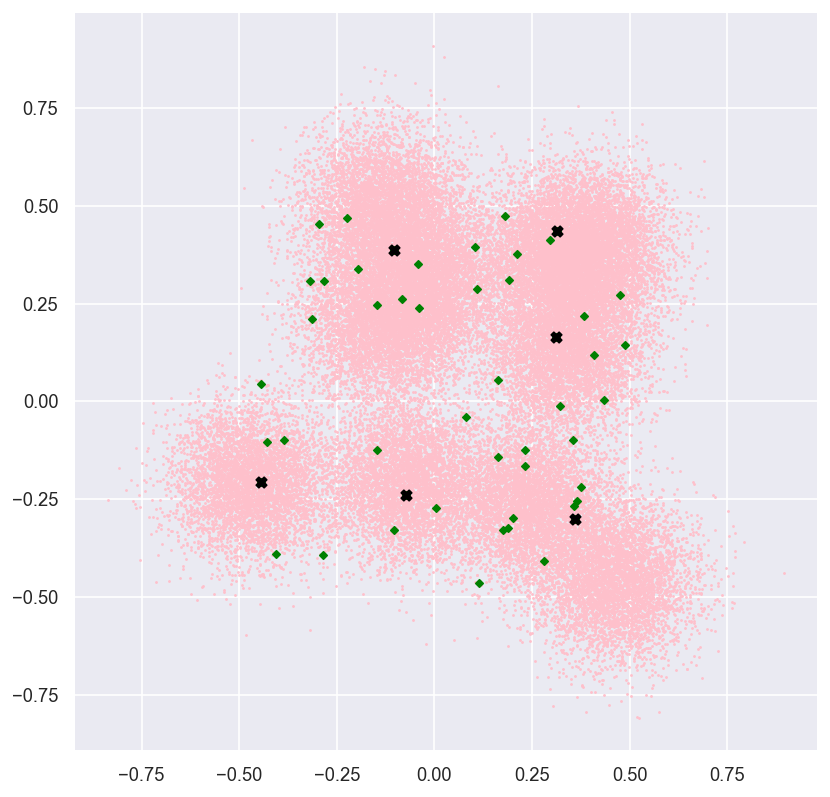

In [25]:
plt.figure(figsize=(8,8), dpi=120)
plt.scatter(*zip(*customer_locs), c='Pink', s=0.5)
plt.scatter(*zip(*facility_locs), c='Green', marker='D', s=10)

selected_locs = [facility_locs[i] for i in range(num_candidates) if select[i].x > 0.5]
plt.scatter(*zip(*selected_locs), c='black', marker='X', s=40)

In [26]:
distance = 0
for p in pairings:
    if assign[p].x > 0.5:
        f_idx, c_idx = p
        distance += dist(facility_locs[f_idx], customer_locs_a[c_idx])

In [27]:
# Objective function
print(f'Sum of the distances from customers and assigned facility: {distance:.3f}')

Sum of the distances from customers and assigned facility: 7558.204


With and without clustering we decide to open the same facilities! However, the clustering approach is **faster**!

Finally, note that the small difference between the objective functions is caused by a different assignment of the customers.

---
## References

1. Drezner, Z., & Hamacher, H. W. (Eds.). (2001). Facility location: applications and theory. Springer Science & Business Media.
2. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
3. Klose, A., & Drexl, A. (2005). Facility location models for distribution system design. European journal of operational research, 162(1), 4-29.